## Overview

When applying the IMOCO pipeline, one challenge has been objectively assessing the processed lung MRI images. The original metrics provided by the IMOCO paper did not fully align with our visual observations. In particular, the previously recommended parameters (e.g., certain lambda values) often led to results that appeared overly smooth, contradicting what the original metrics suggested was optimal.

To address this discrepancy, we aim to explore additional, more automated image quality assessment metrics that better correlate with our visual impressions. Specifically, we will examine image sharpness and noise characteristics. The idea is to identify a complementary set of metrics that can guide us in selecting parameters without requiring extensive manual inspection or masking.

Our approach focuses on three key areas:

1. **Image Sharpness:**  
   We need metrics that ensure the processed images preserve important anatomical details rather than becoming overly smooth. Two well-established indicators are:  
   - **Laplacian Variance:** Measures how much the image deviates from a smooth, flat surface. Higher variance indicates sharper features.  
   - **Gradient Magnitude:** Quantifies the strength of intensity transitions in the image, reflecting edge clarity.

2. **Noise Metrics:**  
   While sharpness metrics help prevent over-smoothing, we must also consider the noise level and signal quality. We will use:  
   - **Entropy:** Captures the complexity and intensity distribution of the image. Excessive noise or irregularities can inflate entropy values.  
   - **Standard Deviation (in a uniform region):** Provides a direct measure of intensity variability. High noise leads to increased variability.

3. **Combining Metrics:**  
   By comparing images across these metrics, we hope to identify parameter sets that produce both visually and quantitatively superior results. Our goal is to find a set of parameters that yield sharp, detailed images with acceptable noise levels—ideally matching what a human observer would consider “good” quality.

In the sections that follow, we will implement these metrics, evaluate different parameter sets, and compare the numerical results to our visual assessments. This process will help us pinpoint which metrics or combinations thereof are most predictive of image quality in lung MRI post-processing.

### 1 - Image Sharpness

#### **Laplacian Variance**
- **Reference:** [PyImageSearch Blog Post](https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv/)
  
#### **Methodology**  
The Laplacian Variance method leverages the Laplacian operator, which is the second derivative of an image. The Laplacian highlights regions with rapid intensity changes, such as edges and fine details.  

The steps are as follows:  
1. Extract a single grayscale channel of the image.  
2. Convolve the image with a **3x3 Laplacian kernel**, which enhances edge-like regions by capturing areas where intensity changes occur abruptly.  
3. Compute the **variance** of the Laplacian-filtered image.  

#### **Intuition**  
- The Laplacian operator emphasizes edges and regions with high spatial frequency in the image.  
- **High variance** of the Laplacian response indicates a wide spread of pixel values, suggesting that the image contains both edge-like and non-edge-like regions. This is typically indicative of a sharp, in-focus image.  
- **Low variance** corresponds to a narrow spread of values, meaning that very few edges or details are present. This is usually the result of excessive smoothing or blurring, where fine anatomical structures are lost.  

#### **Why It Works**  
The variance of the Laplacian acts as a quantitative measure of image sharpness:  
- Sharp, well-focused images have a **high Laplacian variance** due to the presence of many well-defined edges.  
- Overly smoothed or blurred images exhibit a **low Laplacian variance** because intensity transitions are suppressed, leading to fewer discernible edges.  


In [28]:
# utils.py 
import cv2
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_slice(volume, x=None, y=None, z=None):
    if x is not None:
        slice_2d = volume[x, :, :]
        title = f'Slice at X={x}'
    elif y is not None:
        slice_2d = volume[:, y, :]
        title = f'Slice at Y={y}'
    elif z is not None:
        slice_2d = volume[:, :, z]
        title = f'Slice at Z={z}'
    else:
        raise ValueError("One of x, y, or z must be specified")
    
    plt.imshow(slice_2d, cmap='gray')
    plt.title(title)
    plt.show()
    return 

def load_dicom_series(dicom_dir):
    dicom_files = sorted([os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith('.DCM')])
    slices = [pydicom.dcmread(dcm) for dcm in dicom_files]
    slices.sort(key=lambda x: int(x.InstanceNumber)) 
    volume = np.stack([s.pixel_array for s in slices], axis=-1)
    return volume

In [45]:
def variance_of_laplacian(slice):
    # computes the variance of laplacian 
    laplacian = cv2.Laplacian(slice, cv2.CV_64F)
    return laplacian.var()

def dcm_var_of_lap(dicom_vol):
    return [variance_of_laplacian(dicom_vol[slice, : , :]) for slice in range(dicom_vol.shape[0])]

<Axes: >

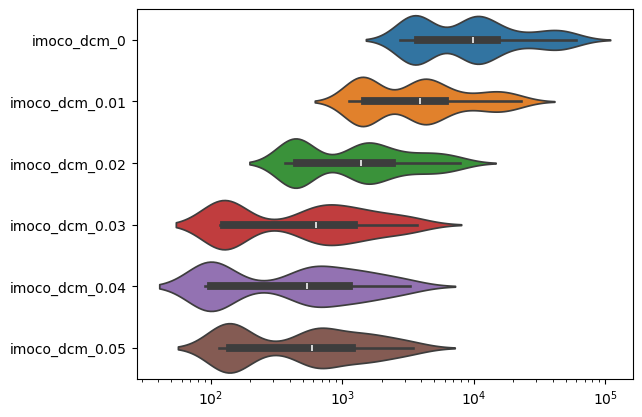

In [46]:
base_folder = '/Users/akshdeepsandhu/Desktop/imoco_lammy_testing/imrh_0110b/'
lammy_variances = {}

for folder_name in sorted(os.listdir(base_folder)):
    if folder_name.startswith('imoco_dcm_'):
        folder_path = os.path.join(base_folder,folder_name)
        dicom_vol  = load_dicom_series(folder_path)
        variance_dcm = dcm_var_of_lap(dicom_vol)
        lammy_variances[folder_name] = variance_dcm

variance_df = pd.DataFrame(lammy_variances)
sns.violinplot(variance_df, orient='h', log_scale=True)

### Summary of results

The above shows the same pattern we saw earlier. The lower lambda values give shaper images, with the increasing lambda smoothing the image quite a bit. This also matches what we saw visually.


#### **Image Gradients (Sobel and Scharr)**  
- **Reference:** [PyImageSearch Blog Post](https://pyimagesearch.com/2021/05/12/image-gradients-with-opencv-sobel-and-scharr/)

#### **Methodology**  

This is another method that works well for detecting edges and sharpness in an image. It’s similar in intuition to the Laplacian variance method but uses a slightly different approach.  

Here, the idea is to find, for each pixel, how fast and in which direction the pixel intensity is changing. A big change in intensity means we are likely moving across an edge or boundary in the image.

To compute this, you  use two gradient components:  
1. **Horizontal gradient $G_x$**: Captures intensity changes in the $x$-direction (left to right).  
2. **Vertical gradient $G_y$**: Captures intensity changes in the $y$-direction (top to bottom).  

The **gradient magnitude** $G$ combines these two components into a single measure that tells you how “strong” the change is:  

$$
G = \sqrt{G_x^2 + G_y^2}
$$

The direction of the gradient can also be calculated using some trig.

$$
\theta = \arctan\left(\frac{G_y}{G_x}\right)
$$

The above normally is done by convolving the image with special kernels:  
- **Sobel Operator**: A 3x3 kernel that gives a good approximation of the gradient.  
- **Scharr Operator**: A slightly more accurate version of Sobel when using a 3x3 kernel (it reduces numerical errors for sharper edges).


#### **Intuition**  
- If the image is sharp, there will be **strong gradients** (i.e., big changes in intensity across edges and boundaries).  
- If the image is overly smoothed, the gradients will be **weak** because edges and fine details are suppressed.  
- The **mean gradient magnitude** or **variance** of the gradients can act as a proxy for sharpness.


#### **Why It Works**  
The Sobel and Scharr operators are efficient and highlight areas of high intensity changes (edges).  
- A sharp image will have **lots of strong gradients** because edges and structures are well-preserved.  
- A blurred or smoothed image will have **weak gradients** as edges are less distinct.






In [57]:
def sobel_grad_magnitude(slice):
    "compute mean sobel filter gradient"
    gX = cv2.Sobel(slice, cv2.CV_64F, dx=1, dy=0, ksize=3)
    gY = cv2.Sobel(slice, cv2.CV_64F, dx=0, dy=1, ksize=3)
    grad = np.sqrt(gX**2 + gY**2)
    return grad.mean()

def scharr_grad_magnitude(slice):
    "compute mean scharr filter gradient"
    gX = cv2.Scharr(slice, cv2.CV_64F, dx=1, dy=0)
    gY = cv2.Scharr(slice, cv2.CV_64F, dx=0, dy=1)
    grad = np.sqrt(gX**2 + gY**2)
    return grad.mean()

def dcm_sobel(dicom_vol):
    return [sobel_grad_magnitude(dicom_vol[slice, : , :]) for slice in range(dicom_vol.shape[0])]

def dcm_scharr(dicom_vol):
    return [scharr_grad_magnitude(dicom_vol[slice, : , :]) for slice in range(dicom_vol.shape[0])]

In [58]:
base_folder = '/Users/akshdeepsandhu/Desktop/imoco_lammy_testing/imrh_0110b/'
lammy_sobel_grad = {}
lammy_scharr_grad = {}

for folder_name in sorted(os.listdir(base_folder)):
    if folder_name.startswith('imoco_dcm_'):
        folder_path = os.path.join(base_folder,folder_name)
        dicom_vol  = load_dicom_series(folder_path)
        sobel_grad_dcm = dcm_sobel(dicom_vol)
        lammy_sobel_grad[folder_name] = sobel_grad_dcm
        scharr_grad_dcm = dcm_scharr(dicom_vol)
        lammy_scharr_grad[folder_name] = scharr_grad_dcm

<Axes: >

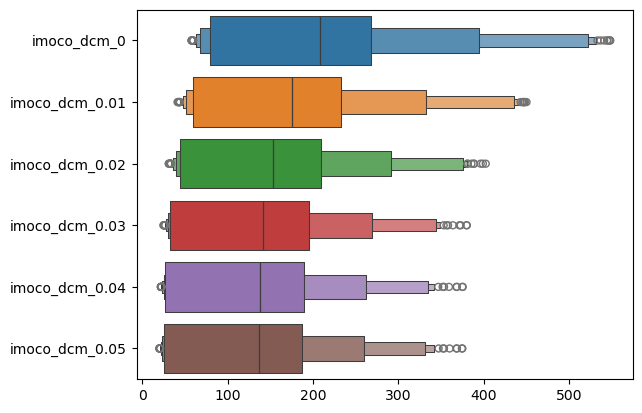

In [62]:
sobel_df = pd.DataFrame(lammy_sobel_grad)
sns.boxenplot(sobel_df, orient='h')

<Axes: >

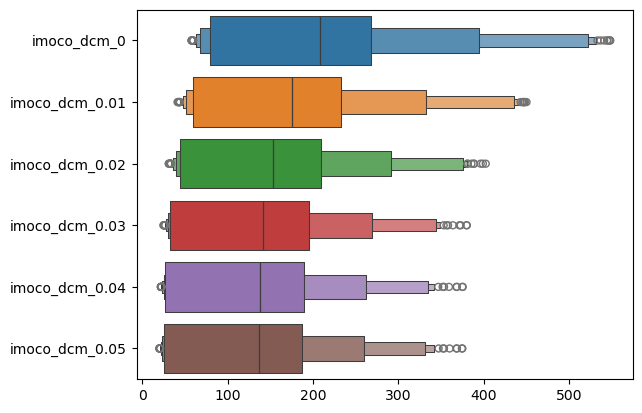

In [61]:
scharr_df = pd.DataFrame(lammy_scharr_grad)
sns.boxenplot(sobel_df, orient='h')

### Summary of results

This is a bit less clear, but again the lower DCM values tend to have higher gradients suggesting that they have sharper images. But differences seem a bit smaller here. 
